In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import (confusion_matrix, roc_curve, auc, precision_recall_curve, 
                             accuracy_score, precision_score, recall_score, f1_score,
                             mean_squared_error, r2_score)
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

enrollment_data = {
    'AY': ['2015-2016', '2015-2016', '2015-2016', '2016-2017', '2016-2017', '2016-2017',
           '2017-2018', '2017-2018', '2017-2018', '2018-2019', '2018-2019', '2018-2019',
           '2019-2020', '2019-2020', '2020-2021', '2020-2021', '2020-2021', '2021-2022',
           '2021-2022', '2021-2022', '2022-2023', '2022-2023', '2022-2023', '2023-2024',
           '2023-2024', '2024-2025', '2024-2025', '2024-2025'],
    'Semester': ['1st', '2nd', 'Midyear', '1st', '2nd', 'Midyear', '1st', '2nd', 'Midyear',
                 '1st', '2nd', 'Midyear', '1st', '2nd', '1st', '2nd', 'Midyear', '1st',
                 '2nd', 'Midyear', '1st', '2nd', 'Midyear', '1st', '2nd', 'Midyear', '1st', '2nd'],
    'Enrollees': [3290, 3096, 759, 2718, 2670, 718, 2466, 2360, 1014, 3541, 3220, 845,
                  3462, 3316, 3976, 3782, 527, 4944, 4726, 1823, 5560, 5080, 1996, 5892,
                  5398, 1574, 6223, 5952]
}

enrollment_df = pd.DataFrame(enrollment_data)

dropout_data = {
    'AY': ['2015-2016', '2015-2016', '2015-2016', '2016-2017', '2016-2017', '2016-2017',
           '2017-2018', '2017-2018', '2017-2018', '2018-2019', '2018-2019', '2018-2019',
           '2019-2020', '2019-2020', '2019-2020', '2020-2021', '2020-2021', '2020-2021',
           '2021-2022', '2021-2022', '2021-2022', '2022-2023', '2022-2023', '2022-2023',
           '2023-2024', '2023-2024', '2023-2024', '2024-2025', '2024-2025', '2024-2025'],
    'Semester': ['First', 'Second', 'Summer', 'First', 'Second', 'Midyear', 'First', 'Second', 'Midyear',
                 'First', 'Second', 'Midyear', 'First', 'Second', 'Midyear', 'First', 'Second', 'Midyear',
                 'First', 'Second', 'Midyear', 'First', 'Second', 'Midyear', 'First', 'Second', 'Midyear',
                 'First', 'Second', 'Midyear'],
    'Dropouts': [56, 47, 11, 35, 29, 7, 57, 24, 5, 66, 39, 9, 62, 59, 0, 40, 9, 1, 39, 21, 15, 39, 40, 4, 86, 20, 17, 50, 23, 0]
}

dropout_df = pd.DataFrame(dropout_data)

semester_mapping = {
    '1st': 'First',
    '2nd': 'Second',
    'Midyear': 'Midyear',
    'Summer': 'Midyear'
}

In [2]:
enrollment_df['Semester'] = enrollment_df['Semester'].map(lambda x: semester_mapping.get(x, x))
dropout_df['Semester'] = dropout_df['Semester'].map(lambda x: semester_mapping.get(x, x))
merged_df = pd.merge(enrollment_df, dropout_df, on=['AY', 'Semester'], how='outer')
merged_df['Dropouts'] = merged_df['Dropouts'].fillna(0)
merged_df['Enrollees'] = merged_df['Enrollees'].fillna(0)
merged_df['Non_Dropouts'] = merged_df['Enrollees'] - merged_df['Dropouts']

In [3]:
def calculate_dropout_rate(row):
    if row['Enrollees'] > 0:
        return round(row['Dropouts'] / row['Enrollees'] * 100, 2)
    return 0

In [4]:
merged_df['Dropout_Rate'] = merged_df.apply(calculate_dropout_rate, axis=1)

merged_df['Year'] = merged_df['AY'].apply(lambda x: int(x.split('-')[0]))

le_semester = LabelEncoder()
merged_df['Semester_Encoded'] = le_semester.fit_transform(merged_df['Semester'])

average_dropout_rate = merged_df['Dropout_Rate'].mean()
merged_df['High_Dropout'] = (merged_df['Dropout_Rate'] > average_dropout_rate).astype(int)

X = merged_df[['Year', 'Semester_Encoded', 'Enrollees']]
y = merged_df['High_Dropout']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

if len(np.unique(y_test)) == 2:
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
else:
    y_pred_proba = np.zeros_like(y_pred, dtype=float)
    if len(y_test) > 0:
        y_pred_proba[y_pred == 1] = 0.99

accuracy = accuracy_score(y_test, y_pred) if len(y_test) > 0 else 0

try:
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
except:
    precision, recall, f1 = 0, 0, 0

fig = plt.figure(figsize=(20, 24))

<Figure size 2000x2400 with 0 Axes>

Text(95.72222222222221, 0.5, 'Actual')

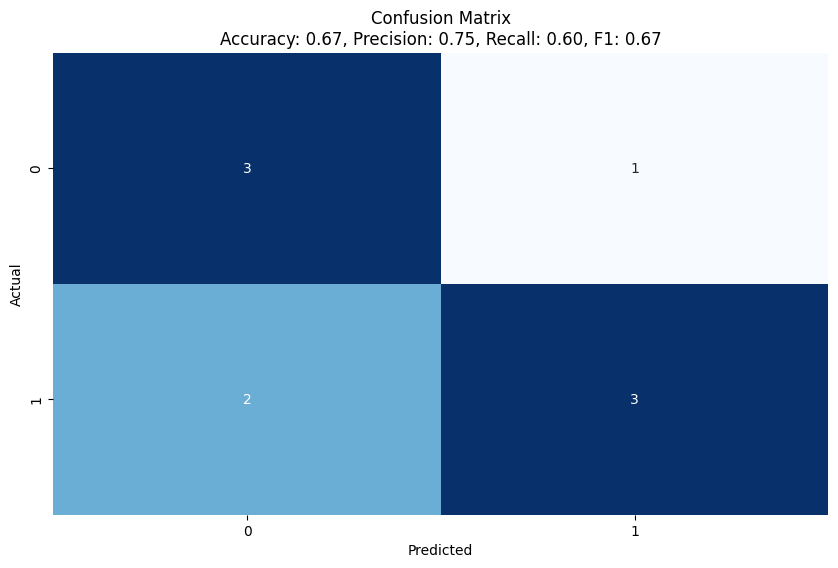

In [5]:
# 1. Confusion Matrix
plt.figure(figsize=(10,6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}')
plt.xlabel('Predicted')
plt.ylabel('Actual')


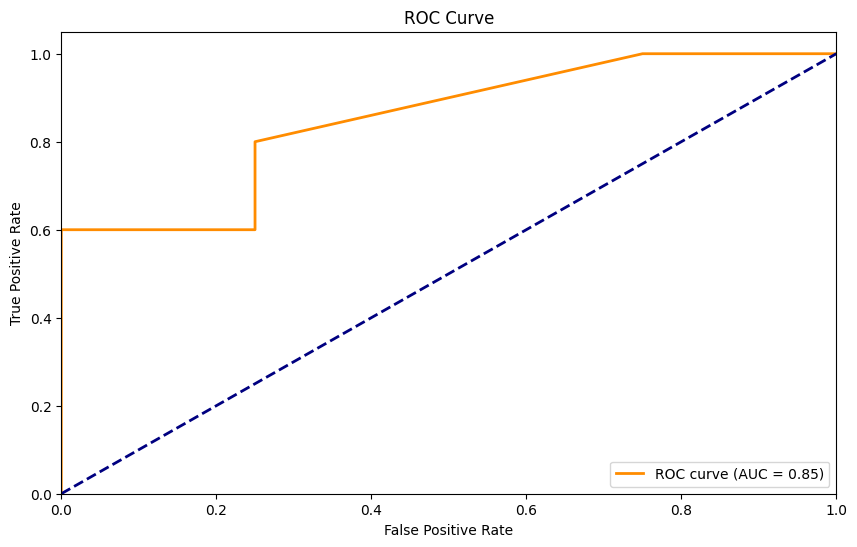

In [6]:
# 2. ROC Curve
plt.figure(figsize=(10,6))
if len(np.unique(y_test)) == 2 and len(np.unique(y_pred_proba)) > 1:
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
else:
    roc_auc = 0.5
    plt.text(0.5, 0.5, 'ROC curve not defined\n(only one class or constant predictions)', 
             horizontalalignment='center', verticalalignment='center', 
             transform=plt.gca().transAxes, fontsize=10)
    plt.title('ROC Curve')

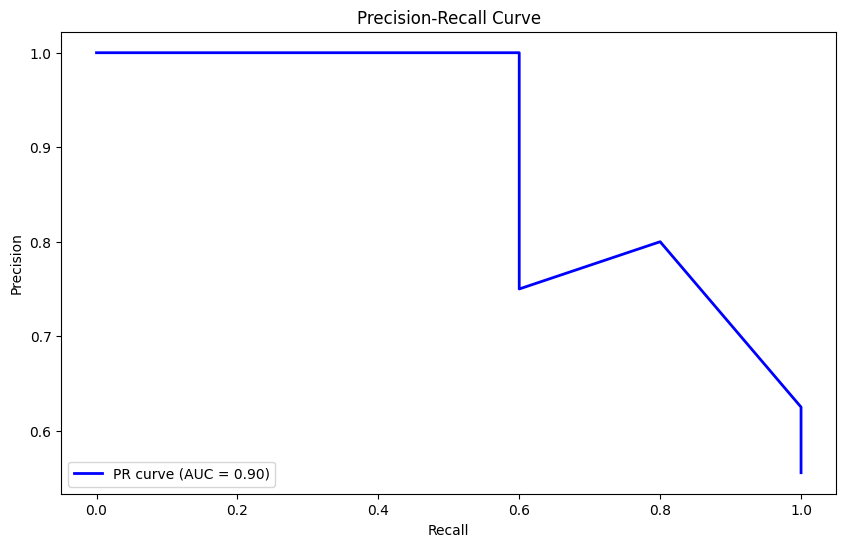

In [7]:
# 3. Precision-Recall Curve
plt.figure(figsize=(10,6))
if len(np.unique(y_test)) == 2 and len(np.unique(y_pred_proba)) > 1:
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
else:
    pr_auc = 0
    plt.text(0.5, 0.5, 'PR curve not defined\n(only one class or constant predictions)', 
             horizontalalignment='center', verticalalignment='center', 
             transform=plt.gca().transAxes, fontsize=10)
    plt.title('Precision-Recall Curve')

Text(0, 0.5, 'Importance')

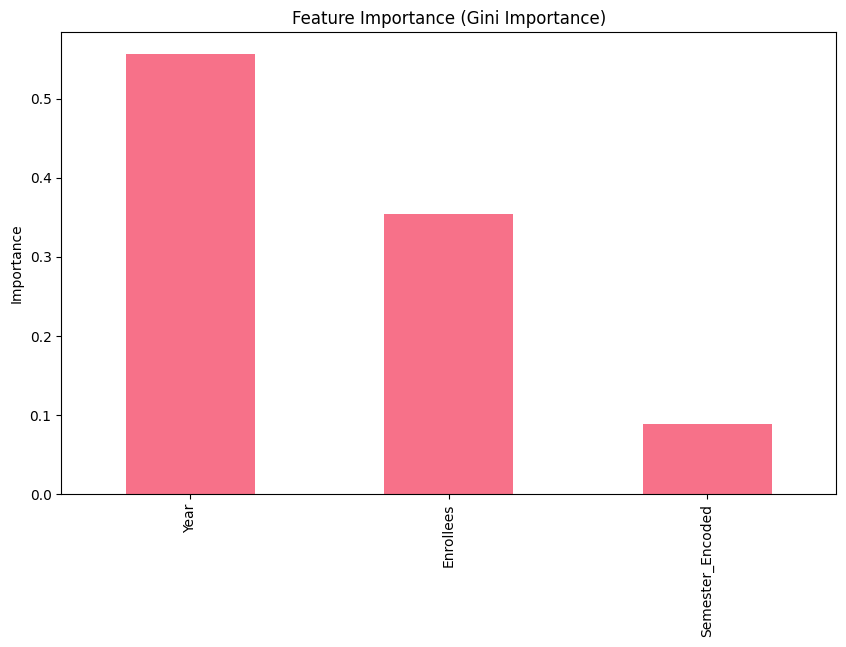

In [8]:
# 4. Feature Importance (Bar Chart)
plt.figure(figsize=(10,6))
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importance (Gini Importance)')
plt.ylabel('Importance')

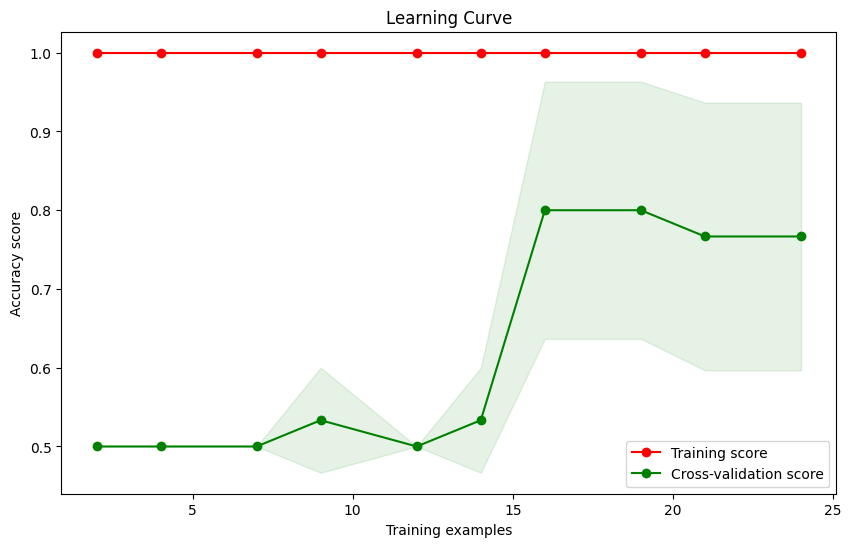

In [9]:
# 5. Learning Curve
plt.figure(figsize=(10,6))
try:
    train_sizes, train_scores, test_scores = learning_curve(
        rf_model, X, y, cv=min(5, len(y)), n_jobs=1, 
        train_sizes=np.linspace(0.1, 1.0, min(10, len(X))),
        scoring='accuracy'
    )
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')
except Exception as e:
    plt.text(0.5, 0.5, f'Learning curve\nnot available: {str(e)}', 
             horizontalalignment='center', verticalalignment='center', 
             transform=plt.gca().transAxes, fontsize=10)
plt.xlabel('Training examples')
plt.ylabel('Accuracy score')
plt.title('Learning Curve')
plt.legend(loc='best')

Text(0.5, 1.0, 'Error Rate vs. Number of Trees')

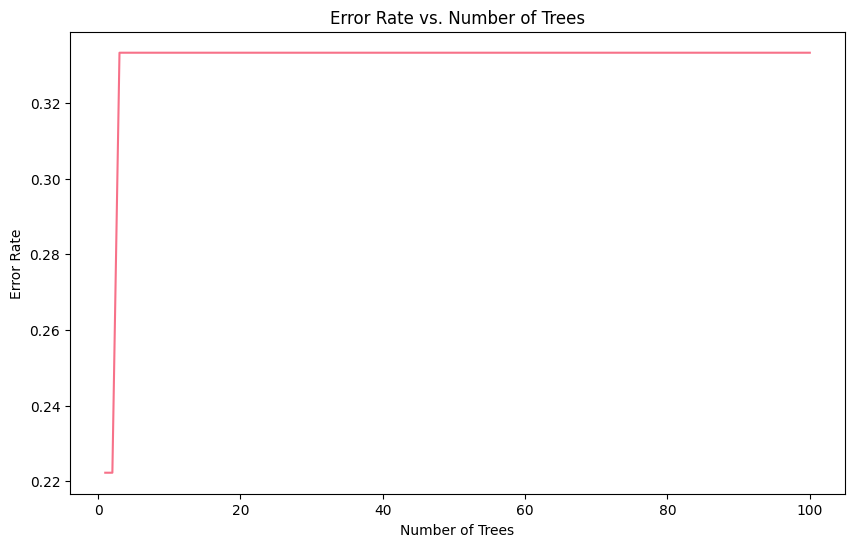

In [10]:
# 6. Error Rate vs. Number of Trees
plt.figure(figsize=(10,6))
errors = []
for n_trees in range(1, 101):
    rf = RandomForestClassifier(n_estimators=n_trees, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    errors.append(1 - accuracy_score(y_test, y_pred))
    
plt.plot(range(1, 101), errors)
plt.xlabel('Number of Trees')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. Number of Trees')

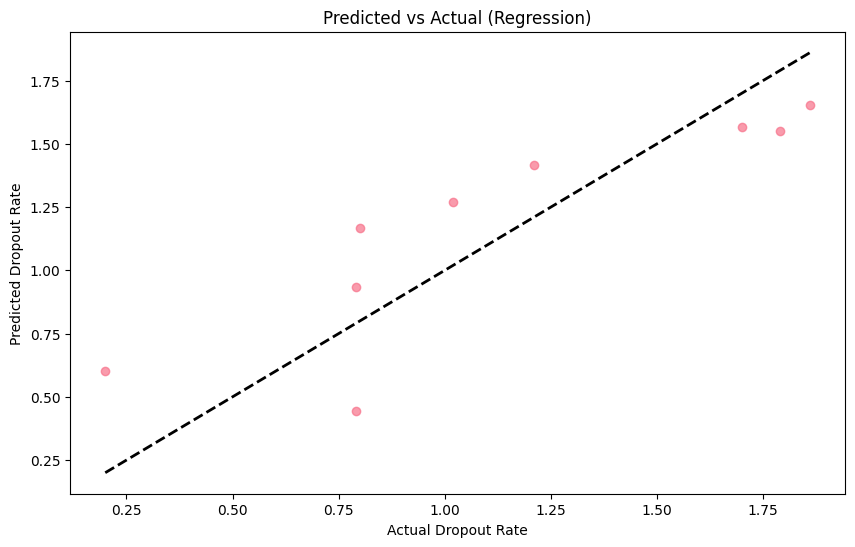

In [11]:
# 7. Predicted vs Actual (for regression)
regression_df = merged_df[(merged_df['Enrollees'] > 0) & (~merged_df['Dropout_Rate'].isna())].copy()
X_reg = regression_df[['Year', 'Semester_Encoded', 'Enrollees']]
y_reg = regression_df['Dropout_Rate']

if len(regression_df) > 0:
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_regressor.fit(X_train_reg, y_train_reg)
    y_pred_reg = rf_regressor.predict(X_test_reg)

    plt.figure(figsize=(10,6))
    plt.scatter(y_test_reg, y_pred_reg, alpha=0.7)
    min_val = min(y_test_reg.min(), y_pred_reg.min())
    max_val = max(y_test_reg.max(), y_pred_reg.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    plt.xlabel('Actual Dropout Rate')
    plt.ylabel('Predicted Dropout Rate')
    plt.title('Predicted vs Actual (Regression)')
else:
    plt.figure(figsize=(10,6))
    plt.text(0.5, 0.5, 'No data for regression', 
             horizontalalignment='center', verticalalignment='center', 
             transform=plt.gca().transAxes, fontsize=12)
    plt.title('Predicted vs Actual (Regression)')

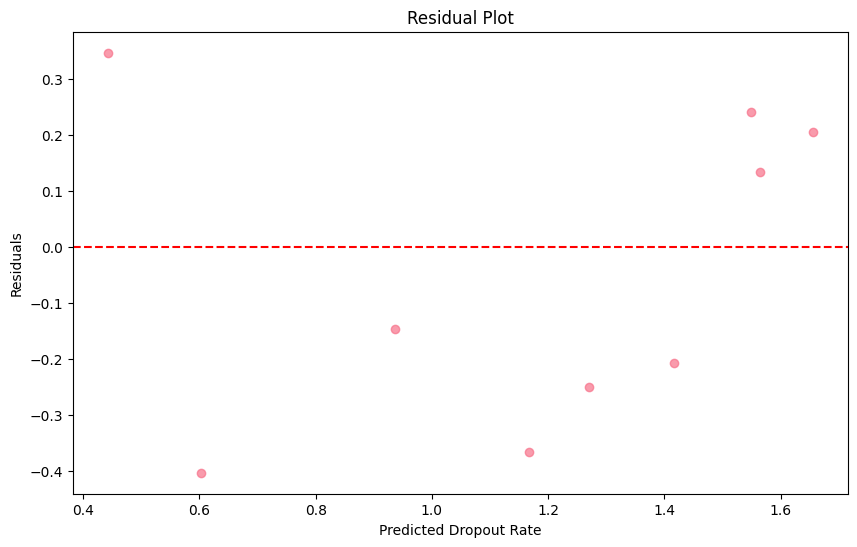

In [12]:
# 8. Residual Plot
plt.figure(figsize=(10,6))
if len(regression_df) > 0 and len(y_test_reg) > 0:
    residuals = y_test_reg - y_pred_reg
    plt.scatter(y_pred_reg, residuals, alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Dropout Rate')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
else:
    plt.text(0.5, 0.5, 'No data for residual plot', 
             horizontalalignment='center', verticalalignment='center', 
             transform=plt.gca().transAxes, fontsize=12)
    plt.title('Residual Plot')

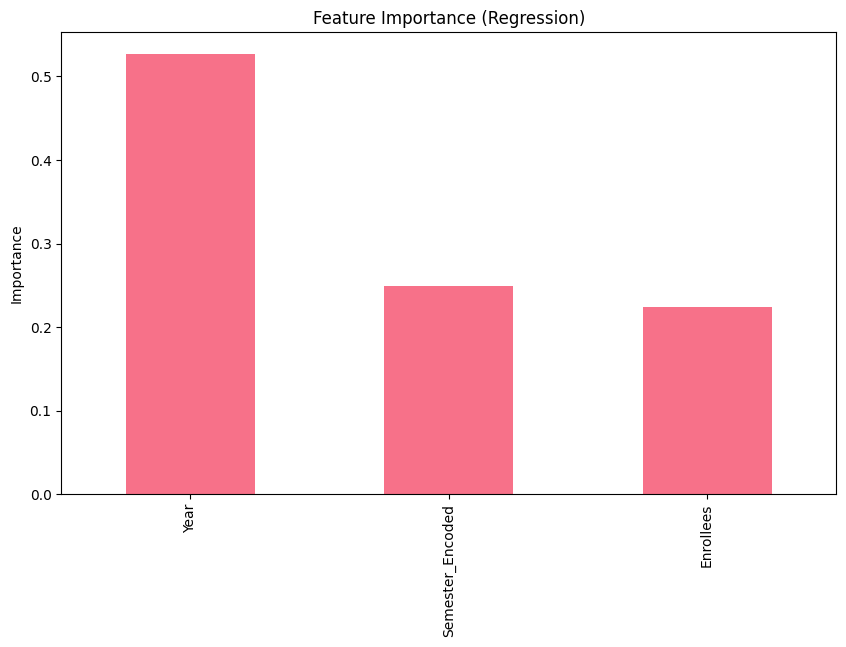

In [13]:
# 9. Feature Importance for Regression
plt.figure(figsize=(10,6))
if len(regression_df) > 0:
    feature_importances_reg = pd.Series(rf_regressor.feature_importances_, index=X_reg.columns)
    feature_importances_reg.sort_values(ascending=False).plot(kind='bar')
    plt.title('Feature Importance (Regression)')
    plt.ylabel('Importance')
else:
    plt.text(0.5, 0.5, 'No data for feature importance', 
             horizontalalignment='center', verticalalignment='center', 
             transform=plt.gca().transAxes, fontsize=12)
    plt.title('Feature Importance (Regression)')

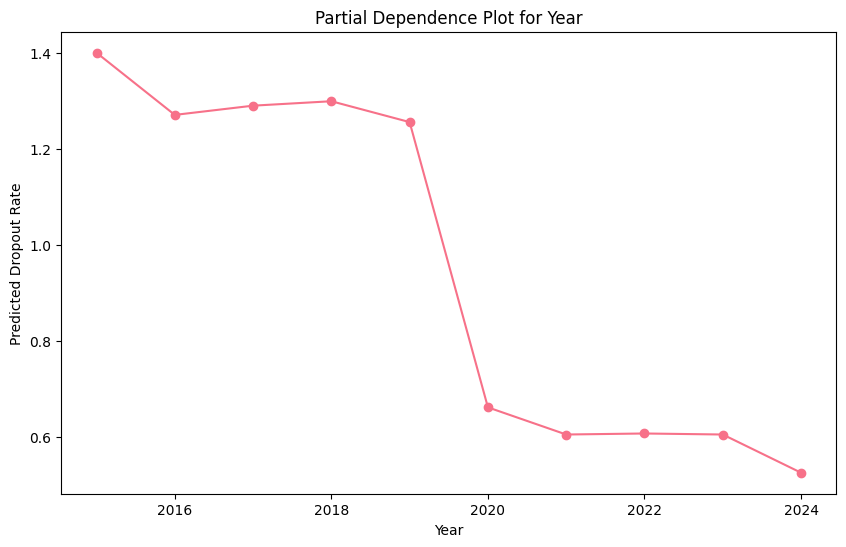

In [14]:
# 10. Partial Dependence Plots (PDP)
plt.figure(figsize=(10,6))
if len(regression_df) > 0:
    most_important_feature = feature_importances_reg.idxmax()
    feature_values = np.sort(regression_df[most_important_feature].unique())
    predicted_means = []

    for value in feature_values:
        temp_df = X_train_reg.copy()
        temp_df[most_important_feature] = value
        predicted_means.append(np.mean(rf_regressor.predict(temp_df)))
    
    plt.plot(feature_values, predicted_means, 'o-')
    plt.xlabel(most_important_feature)
    plt.ylabel('Predicted Dropout Rate')
    plt.title(f'Partial Dependence Plot for {most_important_feature}')
else:
    plt.text(0.5, 0.5, 'No data for PDP', 
             horizontalalignment='center', verticalalignment='center', 
             transform=plt.gca().transAxes, fontsize=12)
    plt.title('Partial Dependence Plot')

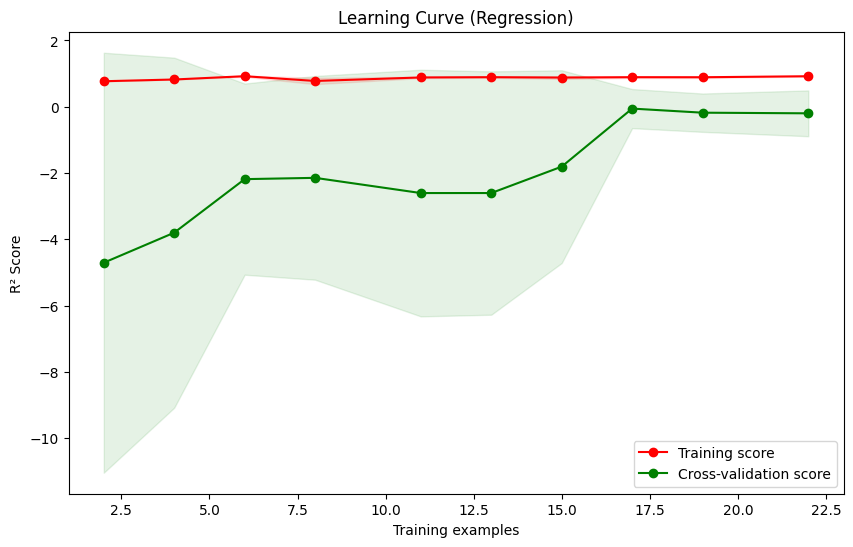

In [15]:
# 11. Learning Curve for Regression
plt.figure(figsize=(10,6))
if len(regression_df) > 0:
    try:
        train_sizes_reg, train_scores_reg, test_scores_reg = learning_curve(
            rf_regressor, X_reg, y_reg, cv=min(5, len(y_reg)), n_jobs=1, 
            train_sizes=np.linspace(0.1, 1.0, min(10, len(X_reg))),
            scoring='r2'
        )
        train_mean_reg = np.mean(train_scores_reg, axis=1)
        train_std_reg = np.std(train_scores_reg, axis=1)
        test_mean_reg = np.mean(test_scores_reg, axis=1)
        test_std_reg = np.std(test_scores_reg, axis=1)

        plt.plot(train_sizes_reg, train_mean_reg, 'o-', color='r', label='Training score')
        plt.plot(train_sizes_reg, test_mean_reg, 'o-', color='g', label='Cross-validation score')
        plt.fill_between(train_sizes_reg, train_mean_reg - train_std_reg, train_mean_reg + train_std_reg, alpha=0.1, color='r')
        plt.fill_between(train_sizes_reg, test_mean_reg - test_std_reg, test_mean_reg + test_std_reg, alpha=0.1, color='g')
    except Exception as e:
        plt.text(0.5, 0.5, f'Learning curve\nnot available: {str(e)}', 
                 horizontalalignment='center', verticalalignment='center', 
                 transform=plt.gca().transAxes, fontsize=10)
else:
    plt.text(0.5, 0.5, 'No data for learning curve', 
             horizontalalignment='center', verticalalignment='center', 
             transform=plt.gca().transAxes, fontsize=12)
plt.xlabel('Training examples')
plt.ylabel('R² Score')
plt.title('Learning Curve (Regression)')
plt.legend(loc='best')

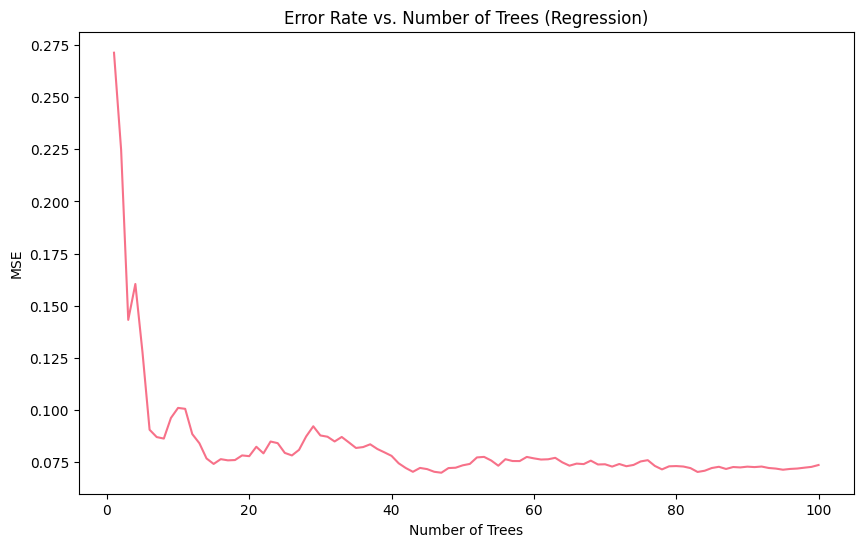

In [16]:
# 12. Error Rate vs. Number of Trees (Regression)
plt.figure(figsize=(10,6))
if len(regression_df) > 0:
    errors_reg = []
    for n_trees in range(1, 101):
        rf = RandomForestRegressor(n_estimators=n_trees, random_state=42)
        rf.fit(X_train_reg, y_train_reg)
        y_pred_reg = rf.predict(X_test_reg)
        errors_reg.append(mean_squared_error(y_test_reg, y_pred_reg))
    
    plt.plot(range(1, 101), errors_reg)
    plt.xlabel('Number of Trees')
    plt.ylabel('MSE')
    plt.title('Error Rate vs. Number of Trees (Regression)')
else:
    plt.text(0.5, 0.5, 'No data for error rate', 
             horizontalalignment='center', verticalalignment='center', 
             transform=plt.gca().transAxes, fontsize=12)
    plt.title('Error Rate vs. Number of Trees (Regression)')

(0.0, 1.0)

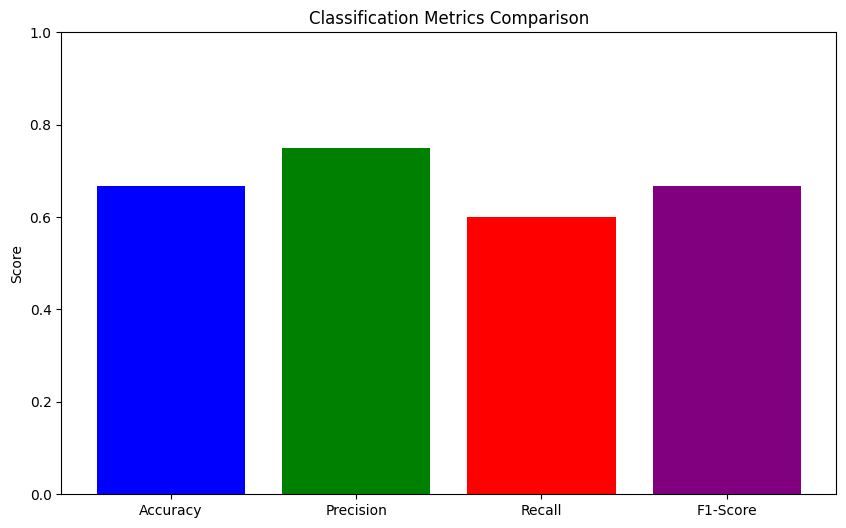

In [17]:
# 13. Classification Metrics Comparison
plt.figure(figsize=(10,6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
plt.title('Classification Metrics Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)

Text(0.5, 1.0, 'Class Distribution')

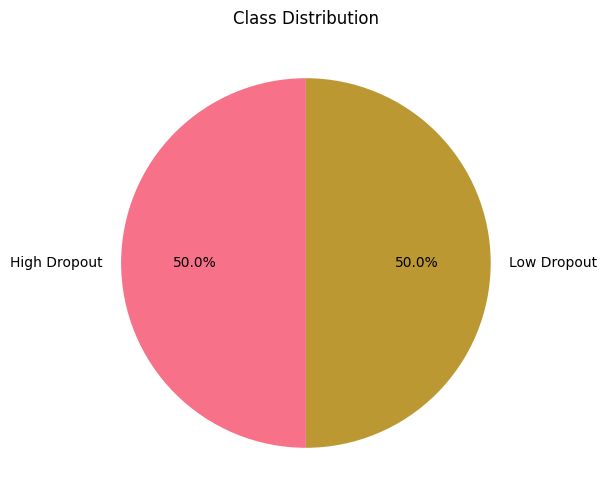

In [18]:
# 14. Class Distribution
plt.figure(figsize=(10,6))
class_counts = merged_df['High_Dropout'].value_counts()
if len(class_counts) > 0:
    labels = ['Low Dropout' if i == 0 else 'High Dropout' for i in class_counts.index]
    plt.pie(class_counts, labels=labels, autopct='%1.1f%%', startangle=90)
else:
    plt.text(0.5, 0.5, 'No class data', 
             horizontalalignment='center', verticalalignment='center', 
             transform=plt.gca().transAxes, fontsize=12)
plt.title('Class Distribution')


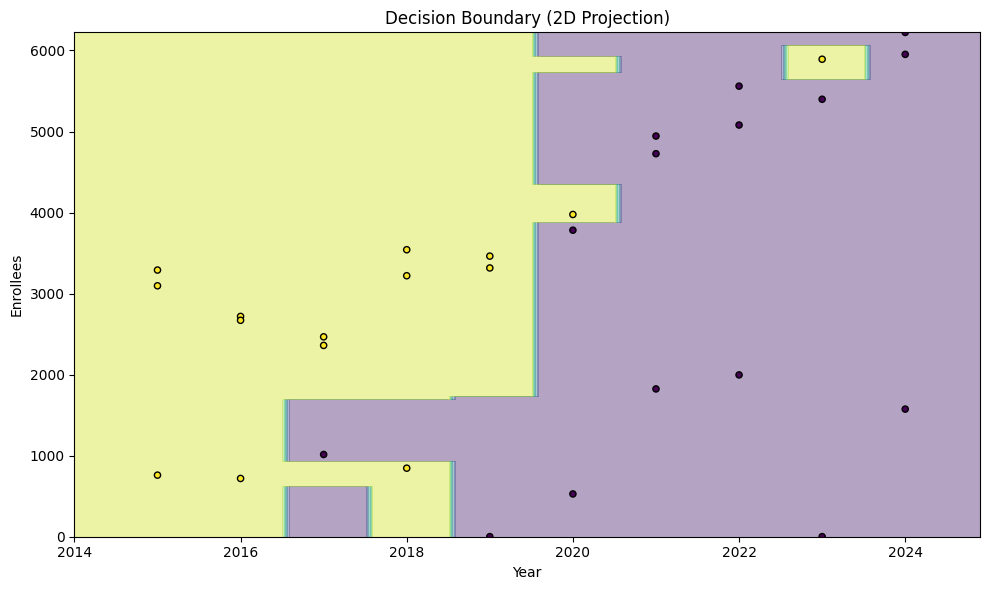

In [20]:
# 15. Decision Boundary Plot (for 2d projection to maam) add ko na rin
plt.figure(figsize=(10,6))
top_features = feature_importances.nlargest(2).index
if len(top_features) >= 2:
    X_2d = merged_df[top_features].values
    y_2d = merged_df['High_Dropout'].values

    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    rf_2d = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_2d.fit(X_2d, y_2d)

    Z = rf_2d.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d, s=20, edgecolor='k')
    plt.xlabel(top_features[0])
    plt.ylabel(top_features[1])
    plt.title('Decision Boundary (2D Projection)')
else:
    plt.text(0.5, 0.5, 'Not enough features\nfor 2D projection', 
             horizontalalignment='center', verticalalignment='center', 
             transform=plt.gca().transAxes, fontsize=12)
    plt.title('Decision Boundary (2D Projection)')

plt.tight_layout()
plt.show()

In [21]:
# model performance metrics
print("Random Forest Classification Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

if len(regression_df) > 0:
    print("\nRandom Forest Regression Performance:")
    r2 = r2_score(y_test_reg, y_pred_reg)
    mse = mean_squared_error(y_test_reg, y_pred_reg)
    print(f"R² Score: {r2:.4f}")
    print(f"MSE: {mse:.4f}")
else:
    print("\nRandom Forest Regression Performance: Not enough data for regression")

print("\nFeature Importance (Classification):")
for feature, importance in feature_importances.sort_values(ascending=False).items():
    print(f"{feature}: {importance:.4f}")

if len(regression_df) > 0:
    print("\nFeature Importance (Regression):")
    for feature, importance in feature_importances_reg.sort_values(ascending=False).items():
        print(f"{feature}: {importance:.4f}")
else:
    print("\nFeature Importance (Regression): Not enough data for regression")

# dataset statistics
print("\nDataset Statistics:")
print(f"Total records: {len(merged_df)}")
print(f"Average dropout rate: {merged_df['Dropout_Rate'].mean():.2f}%")
print(f"High dropout semesters: {merged_df['High_Dropout'].sum()}")
print(f"Low dropout semesters: {len(merged_df) - merged_df['High_Dropout'].sum()}")
print(f"Years covered: {merged_df['Year'].min()} to {merged_df['Year'].max()}")
print(f"Semesters: {', '.join(merged_df['Semester'].unique())}")

# additional insights
print("\nAdditional Insights:")
print(f"Total students: {merged_df['Enrollees'].sum():,}")
print(f"Total dropouts: {merged_df['Dropouts'].sum():,}")
overall_dropout_rate = (merged_df['Dropouts'].sum() / merged_df['Enrollees'].sum() * 100) if merged_df['Enrollees'].sum() > 0 else 0
print(f"Overall dropout rate: {overall_dropout_rate:.2f}%")

max_dropout_idx = merged_df['Dropout_Rate'].idxmax()
print(f"Highest dropout rate: {merged_df.loc[max_dropout_idx, 'Dropout_Rate']:.2f}% in {merged_df.loc[max_dropout_idx, 'AY']} {merged_df.loc[max_dropout_idx, 'Semester']}")

Random Forest Classification Performance:
Accuracy: 0.6667
Precision: 0.7500
Recall: 0.6000
F1-Score: 0.6667
ROC AUC: 0.8500
PR AUC: 0.8975

Random Forest Regression Performance:
R² Score: 0.7369
MSE: 0.0736

Feature Importance (Classification):
Year: 0.5562
Enrollees: 0.3545
Semester_Encoded: 0.0893

Feature Importance (Regression):
Year: 0.5266
Semester_Encoded: 0.2495
Enrollees: 0.2240

Dataset Statistics:
Total records: 30
Average dropout rate: 0.93%
High dropout semesters: 15
Low dropout semesters: 15
Years covered: 2015 to 2024
Semesters: First, Midyear, Second

Additional Insights:
Total students: 90,928.0
Total dropouts: 910
Overall dropout rate: 1.00%
Highest dropout rate: 2.31% in 2017-2018 First
